In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [3]:
from src.analysis import pymc3_analysis as pmanal
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.globals import PYMC3
from src.io import cache_io
from src.modeling import pymc3_sampling_api as pmapi
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 1104
np.random.seed(RANDOM_SEED)

## Example: School absences

The following is from a tutorial in negative binomial regression from UCLA's IDRE: https://stats.idre.ucla.edu/r/dae/negative-binomial-regression/

### Load the data

In [106]:
school_data = pd.read_stata("https://stats.idre.ucla.edu/stat/stata/dae/nb_data.dta")
school_data["id"] = pd.Categorical(school_data["id"].astype(int))

program_cat = {1: "General", 2: "Academic", 3: "Vocational"}
school_data["prog"] = school_data["prog"].astype(int).map(program_cat)
school_data["prog"] = pd.Categorical(
    school_data["prog"], categories=program_cat.values(), ordered=True
)

school_data.head()

,id,gender,math,daysabs,prog
0,1001,male,63.0,4.0,Academic
1,1002,male,27.0,4.0,Academic
2,1003,female,20.0,2.0,Academic
3,1004,female,16.0,3.0,Academic
4,1005,female,2.0,3.0,Academic


### Data viz 

Explore the data, particularly the `daysabs` column.

In [107]:
school_data.describe()

,math,daysabs
count,314.000000,314.000000
mean,48.267517,5.955414
std,25.362392,7.036958
min,1.000000,0.000000
25%,28.000000,1.000000
50%,48.000000,4.000000
75%,70.000000,8.000000
max,99.000000,35.000000


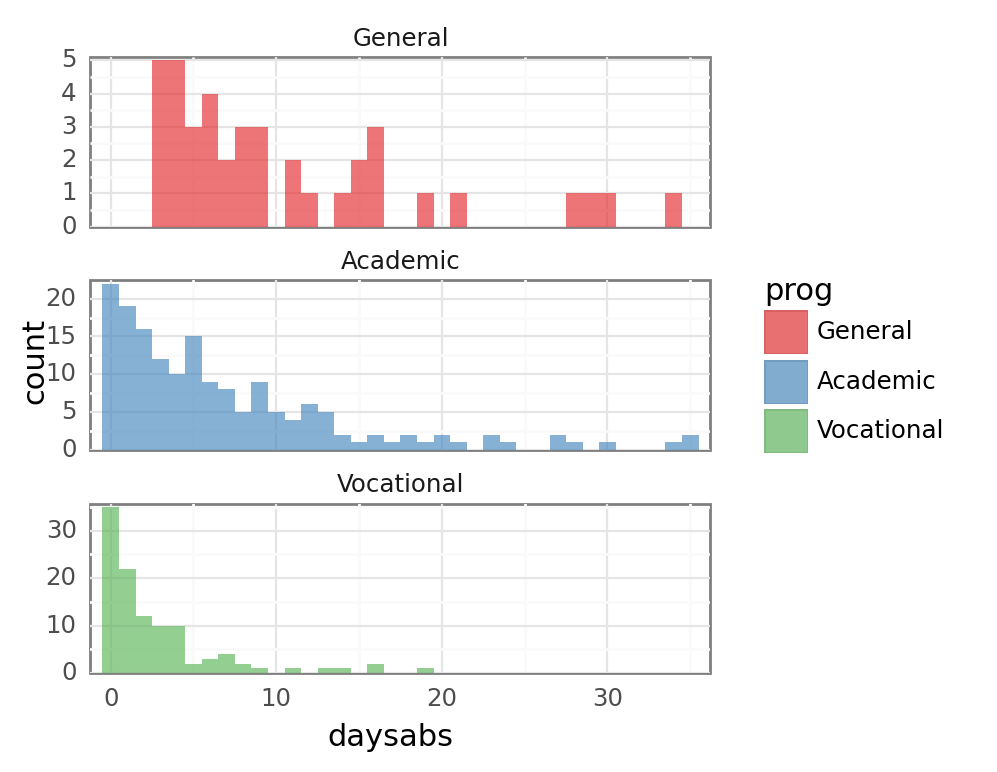

<ggplot: (350211088)>

In [110]:
(
    gg.ggplot(school_data, gg.aes(x="daysabs"))
    + gg.facet_wrap("prog", ncol=1, scales="free_y")
    + gg.geom_histogram(gg.aes(fill="prog"), binwidth=1, alpha=0.6)
    + gg.scale_x_continuous(expand=(0.02, 0, 0.02, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_fill_brewer(type="qual", palette="Set1")
)

In [111]:
school_data.groupby("prog").agg({"daysabs": ["mean", "std"]}).round(2)

daysabs      
              mean   std
prog                    
General      10.65  8.20
Academic      6.93  7.45
Vocational    2.67  3.73

### Negative binomial regression

#### Using the GLM module in PyMC3

In [112]:
x_math = tt.constant(school_data.math.values)
x_prog = tt.constant(pd.get_dummies(school_data.prog).values)
y_daysabs = tt.constant(school_data.daysabs.values)

In [113]:
with pm.Model() as nb:
    β_math = pm.Normal("β_math", 0, 5)
    β_prog = pm.Normal("β_prog", 0, 5, shape=3)
    η = pm.Deterministic("η", pm.math.dot(x_prog, β_prog) + β_math * x_math)
    μ = tt.exp(η)
    α = pm.HalfNormal("α", 5)
    daysabs = pm.NegativeBinomial("daysabs", μ, α, observed=y_daysabs)

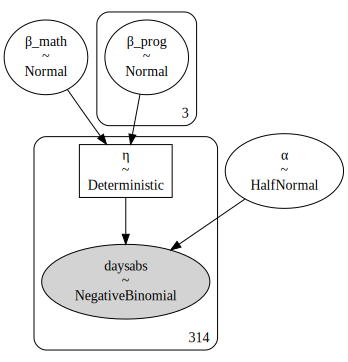

In [114]:
pm.model_to_graphviz(nb)

In [115]:
with nb:
    nb_trace = pm.sample(
        draws=1000, tune=1000, chains=4, cores=2, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [α, β_prog, β_math]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


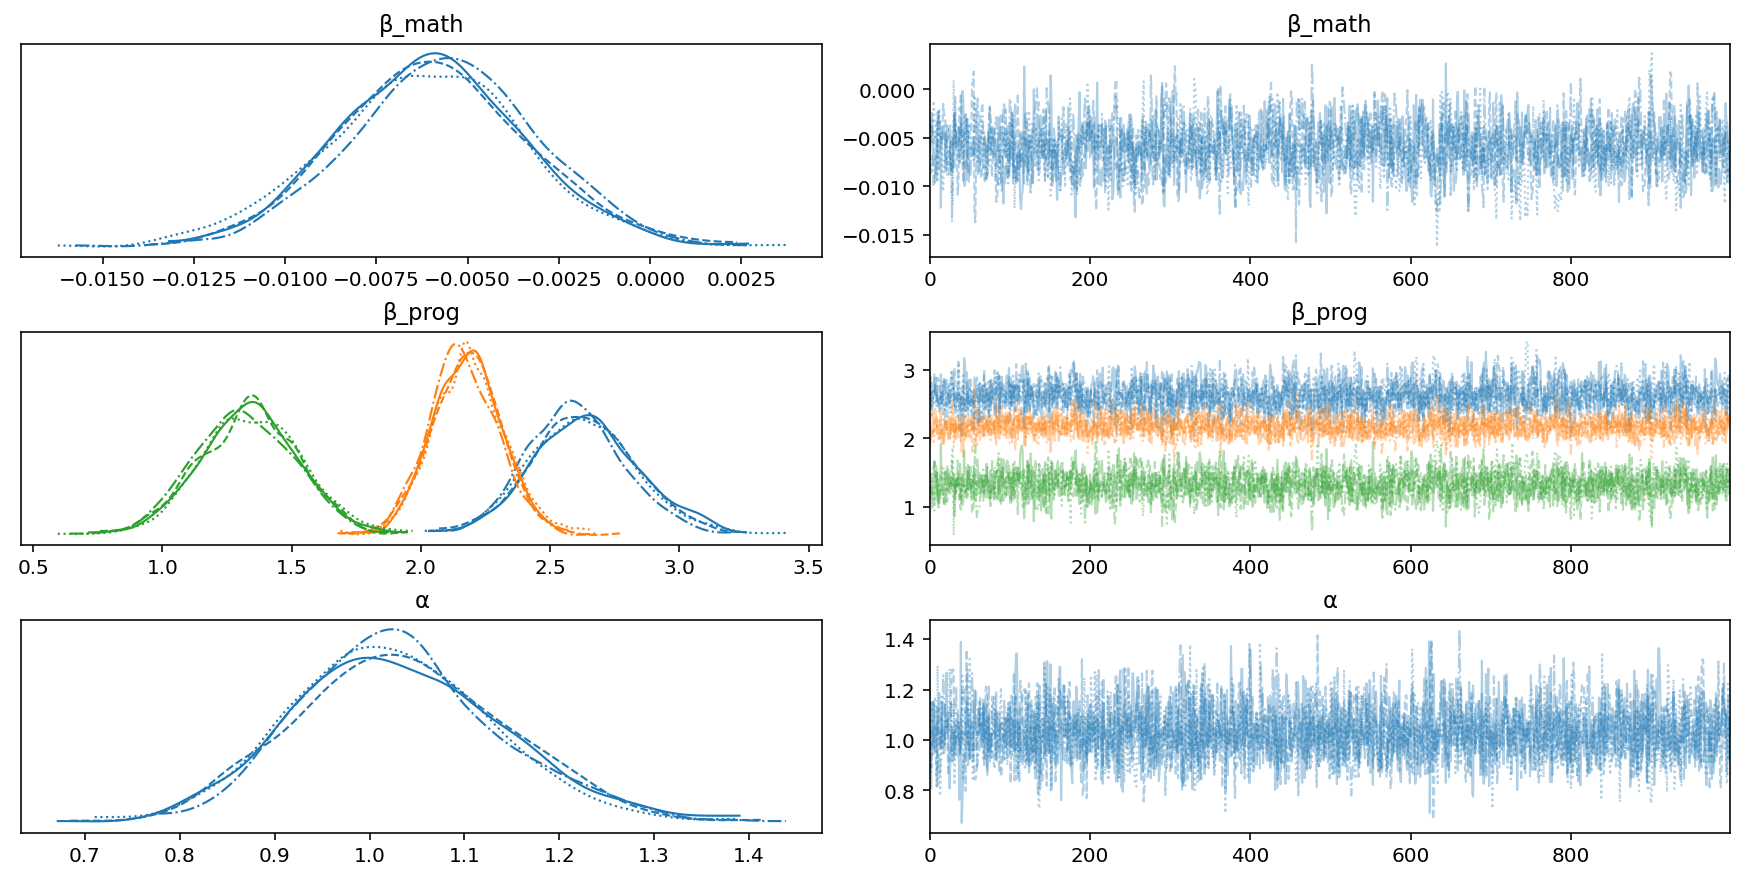

In [116]:
az.plot_trace(nb_trace, var_names=["β_math", "β_prog", "α"]);

In [117]:
az.summary(nb_trace, var_names=["β_prog", "β_math", "α"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_prog[0],2.624,0.202,2.237,3.002,0.005,0.003,1950.0,1666.0,1.0
β_prog[1],2.176,0.135,1.914,2.416,0.003,0.002,1676.0,2176.0,1.0
β_prog[2],1.334,0.193,0.965,1.683,0.005,0.003,1754.0,1966.0,1.0
β_math,-0.006,0.003,-0.011,-0.001,0.000,0.000,1507.0,1821.0,1.0
α,1.030,0.108,0.826,1.229,0.002,0.001,3337.0,2667.0,1.0


---

In [ ]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m